In [1]:
%load_ext autoreload 
%autoreload 2

In [2]:
from ase.io import read
import ase
import time 
from tqdm.notebook import tqdm
from copy import deepcopy
import numpy as np
import scipy as sp
import matplotlib.pyplot as plt

from rascal.representations import SphericalExpansion, SphericalInvariants
from rascal.utils import (get_radial_basis_covariance, get_radial_basis_pca, 
                          get_radial_basis_projections, get_optimal_radial_basis_hypers )
from rascal.utils import radial_basis
from rascal.utils import (WignerDReal, ClebschGordanReal, 
                          spherical_expansion_reshape, spherical_expansion_conjugate,
                    lm_slice, real2complex_matrix, compute_lambda_soap, xyz_to_spherical, spherical_to_xyz)
from rascal.neighbourlist.structure_manager import mask_center_atoms_by_species,mask_center_atoms_by_id

Original error:
No module named 'sklearn.utils._tags'


In [3]:
from skcosmo.linear_model import AtomRidge
from skcosmo.model_selection import atom_groups_by_frame, train_test_split_by_frame

In [4]:
from skcosmo.model_selection import 

SyntaxError: invalid syntax (<ipython-input-4-ff0087a4ad30>, line 1)

In [5]:
help(atom_groups_by_frame)

Help on function atom_groups_by_frame in module skcosmo.model_selection._split:

atom_groups_by_frame(frames)
    Creates a list of group IDs associated with a series of ASE frames that
    point to the frame each atom center belongs to. If present, does the indexing
    referring only to the atoms selected by the `center_atoms_mask` array.
    
    Parameters
    ----------
    frames: list of ASE atom frames, used to infer the indexing of atoms to frames.
            all the atoms with `center_atom_mask[i] = True` are considered to be
            active - i.e. the targets will contain a list of all such atoms, in the
            same order as they appear in the frames.
    
    Returns
    -------
    groups: frame IDs for all the active atoms in the data set



In [6]:
help(AtomRidge.fit)

Help on function fit in module skcosmo.linear_model._atom_ridge:

fit(self, X, y, sample_sigmas=None)



In [7]:
help(train_test_split_by_frame)

Help on function train_test_split_by_frame in module skcosmo.model_selection._split:

train_test_split_by_frame(frames, *arrays, **options)
    Splits a dataset of atom-centered data into train and test sets along
    frame boundaries, using GroupShuffleSplit and atom_groups_by_frame to
    determine the list of frame IDs of each atomic center. Also returns a
    list of frame IDs for each of the train and test samples, that can be
    used to further keep the frames together in CV folding.
    
    Parameters
    ----------
    frames: list of ASE atom frames, used to infer frame indexing (see also
            `atom_groups_by_frame`
    
    *arrays, **options: arrays to perform the splitting, will be passed as
            arguments to GroupShuffleSplit
    
    Returns
    -------
    [train, test, ...], group_train, group_test :
            sequence of (train, test) splits of each array, plus the split of
            the frame IDs



In [8]:
frames = read("./train_tensor/CSD-3k+S546_shift_tensors.xyz",":")
clean_frames = []
for f in frames:
    if f.info['STATUS'] == 'PASSING':
        clean_frames.append(f)
    else:
        pass
        #print(f.info['NAME'], f.info['STATUS'])

In [9]:
frames[0].arrays

{'numbers': array([7, 7, 7, 7, 8, 8, 8, 8, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6,
        6, 6, 6, 6, 6, 6, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
        1, 1, 1, 1]),
 'positions': array([[4.20583137e+00, 1.25509489e+00, 3.87305102e+00],
        [1.09878552e+01, 1.64241627e+00, 1.73096237e+00],
        [9.35821623e+00, 4.15260604e+00, 4.53296907e+00],
        [2.57619243e+00, 4.53992742e+00, 1.07104433e+00],
        [4.79432114e+00, 2.10391940e-01, 1.89885815e+00],
        [1.15763449e+01, 2.68711921e+00, 3.70515524e+00],
        [8.76972646e+00, 3.10790310e+00, 9.03148550e-01],
        [1.98770266e+00, 5.58463037e+00, 4.70086485e+00],
        [4.95197606e+00, 1.17802397e+00, 2.68591201e+00],
        [1.17339999e+01, 1.71947362e+00, 2.91810138e+00],
        [8.61207154e+00, 4.07553512e+00, 1.16094680e-01],
        [1.83004774e+00, 4.61698478e+00, 5.48793227e+00],
        [5.86558249e+00, 2.27275112e+00, 2.47581848e+00],
        [1.26476063e+01, 6.24760030e-01, 3.12820848e

In [9]:
len(frames)

3546

In [5]:
%config IPCompleter.use_jedi = False

In [8]:
from nice.utilities import get_all_species

In [ ]:
for atom_number in all_atom_numbers:
    # get bindicts
    # get features
    # then do feature selection:
    # get absolut IDs as feature_IDs
    # build dict that containes entries of {feature_ID:FRAME}
    # 

In [31]:
frames[0].numbers

array([7, 7, 7, 7, 8, 8, 8, 8, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6,
       6, 6, 6, 6, 6, 6, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1])

In [209]:
atomic_numbers = np.concatenate([frame.numbers for frame in frames[-100:]])
all_species = np.unique(atomic_numbers).tolist()

In [210]:
all_species

[1, 6, 7, 8, 16]

In [203]:
i_selected = np.array([1,2,3,4,5,6,7,8,370])
selected_ids = i_selected


def return_relative_inds(frames, selected_ids, atom_type):
    #TODO: Test this!
    """helper function that returns a numpy array of shape (N_environments_selected, 2)
       entries contain CSD identifier and 
    """
    
    accum_numbers = np.array([len(frame) for frame in frames])

    #bins with accumulated count of atomic environments
    bins = np.cumsum(accum_numbers)

    #array with atomic indices
    frame_names = np.array([frame.info["NAME"] for frame in frames])

    #atomic numbers of all the cumulated atomic environments
    atomic_numbers = np.concatenate([frame.numbers for frame in frames]) 

    #atomic numbers split environments 
    all_species = np.unique(atomic_numbers).tolist()
    number_loc = {i: np.where(atomic_numbers == i)[0] for i in all_species}

    #we get from a X_raw of one atomtype of environment the selected ids (atom_type, selected_ids)
    #first, we convert them into total ids:
    number_loc_absolute = number_loc[atom_type][selected_ids]

    #now convert them into binned environments
    in_bin = np.digitize(number_loc_absolute, bins)
    in_bin_names = frame_names[in_bin]

    #what is left are relative selections within structure (1st in structure A, 0th in structure B)
    #how to? substract in bin[0] with 0, substract in bin[1] with accum[0] in bin[2] with accum[1] etc....
    #add accum_numbers_bin[0] to all

    #find a better solution for this, this is not smart
    bins_concat = np.concatenate([np.array([0]),bins])
    inds_relative = number_loc_absolute - bins_concat[in_bin]

    #finally return dict/np.array with the selected ids
    return np.vstack((in_bin_names,inds_relative)).T


In [223]:
len(clean_frames)

3430

In [222]:
return_relative_inds(clean_frames[-100:], [1,50,500,800], 8)

IndexError: index 800 is out of bounds for axis 0 with size 750

In [221]:
return_relative_inds(clean_frames, i_selected, 1)

array([['PYRIDO04', '29'],
       ['PYRIDO04', '30'],
       ['PYRIDO04', '31'],
       ['PYRIDO04', '32'],
       ['PYRIDO04', '33'],
       ['PYRIDO04', '34'],
       ['PYRIDO04', '35'],
       ['PYRIDO04', '36'],
       ['DAZVEF', '60']], dtype='<U21')

In [200]:
struct_name_relative_ind

array([['PYRIDO04', '29'],
       ['PYRIDO04', '30'],
       ['PYRIDO04', '31'],
       ['PYRIDO04', '32'],
       ['PYRIDO04', '33'],
       ['PYRIDO04', '34'],
       ['PYRIDO04', '35'],
       ['PYRIDO04', '36'],
       ['DAZVEF', '60']], dtype='<U21')

In [202]:
frames[8][60]

Atom('H', [3.99426644, 9.937785740000002, 7.10353254], index=60)

In [160]:
inds_relative

array([29, 30, 31, 32, 33, 34, 35, 36, 70])

In [147]:
bins_concat

array([     0,     48,    118, ..., 340743, 340817, 340941])

In [136]:
number_loc_absolute

array([ 29,  30,  31,  32,  33,  34,  35,  36, 880])

In [137]:
in_bin-1

array([-1, -1, -1, -1, -1, -1, -1, -1,  6])

In [132]:
bins[in_bin]

array([ 48,  48,  48,  48,  48,  48,  48,  48, 940])

In [127]:
accum_numbers[0]

48

In [138]:
number_loc_absolute

array([ 29,  30,  31,  32,  33,  34,  35,  36, 880])

In [125]:
in_bin_names

array(['PYRIDO04', 'PYRIDO04', 'PYRIDO04', 'PYRIDO04', 'PYRIDO04',
       'PYRIDO04', 'PYRIDO04', 'PYRIDO04', 'FEHCUQ'], dtype='<U8')

In [144]:
inds_relative

array([ 29,  30,  31,  32,  33,  34,  35,  36, 136])

In [121]:
number_loc_absolute

array([ 29,  30,  31,  32,  33,  34,  35,  36, 890])

In [98]:
type(accum_numbers)

list

In [97]:
accum_numbers[in_bin.astype("int")]

TypeError: only integer scalar arrays can be converted to a scalar index

In [88]:
in_bin.dtype

dtype('int64')

In [89]:
accum_numbers[0]

48

In [76]:
selection

'TUHHUZ'

In [73]:
np.unique(atomic_numbers)

array([ 1,  6,  7,  8, 16])

In [57]:
frame_names[in_bin]

array(['PYRIDO04', 'PYRIDO04', 'PYRIDO04', 'PYRIDO04', 'PYRIDO04',
       'PYRIDO04', 'PYRIDO04', 'PYRIDO04'], dtype='<U8')

In [49]:
np.cumsum(accum_numbers)

array([    48,    118,    226, ..., 340743, 340817, 340941])

In [48]:
len(accum_numbers)

3546

In [45]:
len(frames)

3546

In [29]:
bindict = {frame.info["NAME"]:[] for frame in frames} #dict with all the frames
selected_to_frame = { number : frame.info["NAME"] for n, frame in zip(frames) for number in len(frame) }

In [30]:
selected_to_frame

{7: 'HEMYON', 8: 'HEMYON', 6: 'HEMYON', 1: 'HEMYON', 16: 'HEMYON'}

In [ ]:
[entry for tag in tags for entry in entries if tag in entry]

In [27]:
bindict

{'PYRIDO04': [],
 'MODYOU': [],
 'ELIGOX': [],
 'TUHHUZ': [],
 'CSURCD10': [],
 'DAVARO': [],
 'BOZGIH': [],
 'FEHCUQ': [],
 'DAZVEF': [],
 'PUBMUU23': [],
 'MOKPUX': [],
 'TEOXDE01': [],
 'RIGJOG': [],
 'BINROF': [],
 'UPONAQ': [],
 'HMBFUR': [],
 'RAYLAE': [],
 'VABLIT': [],
 'UREJAD': [],
 'XURCIW': [],
 'MCBPCX': [],
 'DOXKOR': [],
 'UDURUH': [],
 'DALGON03': [],
 'XUHPIB': [],
 'TABFAG': [],
 'MEWSUE': [],
 'KENMOF': [],
 'BUXWIA': [],
 'KIFJAK': [],
 'JEXZUH': [],
 'GAFWIV': [],
 'EXIGAU': [],
 'ULEZES': [],
 'RIZZEH': [],
 'XIBTUY': [],
 'SITQET': [],
 'FIZJON01': [],
 'NEPBEQ': [],
 'TRZPUR': [],
 'HOFLAQ01': [],
 'BUWCAX': [],
 'AMTETA': [],
 'DIHIXL10': [],
 'ZIPSIC': [],
 'BOQQUT08': [],
 'SEYJAH': [],
 'DOYTUG': [],
 'NEHQAU': [],
 'TUPWEI': [],
 'YITKAP': [],
 'VOBJEB': [],
 'AZOXCH': [],
 'GIVXUE': [],
 'INEZUY': [],
 'XOMWAX': [],
 'XOKXIE': [],
 'NERJIE': [],
 'EFUMAU02': [],
 'APENOA': [],
 'GACLEE': [],
 'NTRACD': [],
 'SIBFOA': [],
 'EVIQAB': [],
 'OCPNDN': [],
 'FUG

In [ ]:
def get_type_ids(frames):
    idx = 0
    type_numbers = {number: [] for number in get_all_species(frames).to_list()}
    numbers_frame_accum = type_numbers
    for frame in frames:
        for atom in frame.numbers:
    
            
    pass

In [64]:
atomic_numbers = np.concatenate([frame.numbers for frame in frames]) 
number_loc = {i: np.where(atomic_numbers == i)[0] for i in [1, 6, 7, 8]}

In [70]:
number_loc[1][i_selected]

array([29, 30, 31, 32, 33, 34, 35, 36])

In [72]:
np.where(frames[0].numbers == 1)

(array([28, 29, 30, 31, 32, 33, 34, 35, 36, 37, 38, 39, 40, 41, 42, 43, 44,
        45, 46, 47]),)

In [10]:
y = []
ty = []
s = []
atom_sigma = {'H': 0.1, 'C': 1, 'N':1, 'O':1, 'S':2}
type_idx = {'H': [], 'C': [], 'N': [], 'O': [], 'S': []}
idx = 0
groups = []
for iframe, f in enumerate(frames):
    y.append(f.arrays['cs_iso'])
    ty.append(f.arrays['cs_tensor'].reshape((-1,3,3)))
    f.wrap(eps=1e-12)
    for l in f.symbols:
        type_idx[l].append(idx)
        idx+=1
        s.append(atom_sigma[l])    
groups = atom_groups_by_frame(frames)        
cs = np.concatenate(y)
tcs = np.concatenate(ty)
sigmas = np.asarray(s)

In [14]:
len(groups) #is total indices of atomic indices


340941

In [20]:
#this = train_test_split_by_frame(frames)

In [7]:
f.info

{'magres_units': {'cs_tensor': 'ppm', 'cs_iso': 'ppm'},
 'STATUS': 'PASSING',
 'NAME': 'FADBOB',
 'ENERGY': -2300.05217586}

In [13]:
frames = frames[-100:]

In [15]:
hypers_1 = {
    'interaction_cutoff': 6,
    'max_radial': 10,
    'max_angular': 0,
    'gaussian_sigma_type': 'Constant',
    'gaussian_sigma_constant': 0.2,
    'cutoff_smooth_width': 0.3,
    'radial_basis': 'DVR',        
    'soap_type' : "RadialSpectrum",
    'normalize' : False
}

hypers_2 = {
    'interaction_cutoff': 6,
    'max_radial': 8,
    'max_angular': 6,
    'gaussian_sigma_type': 'Constant',
    'gaussian_sigma_constant': 0.2,
    'cutoff_smooth_width': 0.3,
    'radial_basis': 'DVR',
    'normalize' : False,
    'soap_type' : "PowerSpectrum"
}

hypers_1 = get_optimal_radial_basis_hypers(hypers_1, frames, expanded_max_radial=20)
#hypers_2 = get_optimal_radial_basis_hypers(hypers_2, frames, expanded_max_radial=50)

In [24]:
import json

In [27]:
with open("hypers_1.json", 'w') as f: 
    json.dump(hypers_1, f)

In [23]:
hypers_1["optimization"]["RadialDimReduction"]['projection_matrices'][8]

[[[-0.08469535809523869,
   -0.5686583802185792,
   -0.7197209668513921,
   -0.12821259177343627,
   -0.004098006449016495,
   -0.010720797870861373,
   -0.01205101304126996,
   -0.04366820381386255,
   -0.11920661495849395,
   -0.0821762381341865,
   -0.11995516860182065,
   -0.12265198334987305,
   -0.13190032074998065,
   -0.15845614140530825,
   -0.1671617923817393,
   -0.10739372800482049,
   -0.021267808777168364,
   -0.0017251717288386443,
   -0.00012711177032230782,
   -1.6529079046109e-05],
  [0.03298753588324479,
   0.22148290426312364,
   0.28027945817611016,
   0.048276062820857744,
   -0.02340484077051256,
   -0.09048472200407941,
   -0.09746199705137285,
   -0.07810880162877244,
   -0.19258683066885535,
   -0.2662092481355976,
   -0.3356676619200806,
   -0.3381532965027015,
   -0.3712272601538803,
   -0.3909729568786146,
   -0.39120469971407423,
   -0.2517023148105238,
   -0.05074225740202574,
   -0.004222599821955457,
   -0.00031667625726824523,
   -4.153023254747151e-05

In [12]:
340941*2450

835305450

In [8]:
soap1 = SphericalInvariants(**hypers_1)
soap2 = SphericalInvariants(**hypers_2)

In [9]:
feat1 = soap1.transform(frames).get_features(soap1)
feat2 = soap2.transform(frames).get_features(soap2)

In [10]:
from sklearn.model_selection import GroupKFold, GridSearchCV, train_test_split

In [11]:
from skcosmo.kernel_model import RKHSTransform
from skcosmo.sample_selection import CUR, PCovCUR, FPS

In [12]:
feats = np.hstack([feat1, feat2])
X_train, X_test, y_train, y_test, sig_train, sig_test, g_train, g_test = train_test_split_by_frame(frames, feats, cs, sigmas, train_size=0.8)

In [13]:
ar = AtomRidge(sigma=1, delta=[10, 2], feature_groups=[slice(0,feat1.shape[1]), slice(feat1.shape[1],feat1.shape[1]+feat2.shape[1])])

In [14]:
splits = list(GroupKFold(n_splits=2).split(X_train, y_train, g_train))
gcv = GridSearchCV(ar, dict(delta=[[1,100], [1,10], [1, 1], [10, 1], [100,1]]), cv = splits, scoring='neg_mean_squared_error')

In [15]:
ar.fit(X_train, y_train, sample_sigmas=sig_train)

In [16]:
gcv.fit(X_train, y_train, sample_sigmas=sig_train)

GridSearchCV(cv=[(array([    0,     1,     2, ..., 12545, 12546, 12547]),
                  array([  172,   173,   174, ..., 12397, 12398, 12399])),
                 (array([  172,   173,   174, ..., 12397, 12398, 12399]),
                  array([    0,     1,     2, ..., 12545, 12546, 12547]))],
             estimator=AtomRidge(delta=[10, 2],
                                 feature_groups=[slice(0, 50, None),
                                                 slice(50, 6770, None)],
                                 sigma=1),
             param_grid={'delta': [[1, 100], [1, 10], [1, 1], [10, 1],
                                   [100, 1]]},
             scoring='neg_mean_squared_error')

In [17]:
gcv.cv_results_

{'mean_fit_time': array([12.62226784, 11.41047299, 10.33597493, 10.8238939 , 11.28379452]),
 'std_fit_time': array([0.85140407, 0.25386012, 1.32430291, 0.82745206, 0.48295629]),
 'mean_score_time': array([1.31691337, 1.46901071, 1.0062598 , 1.15554893, 1.98514438]),
 'std_score_time': array([0.37100816, 0.07117593, 0.06159365, 0.19415653, 0.04891634]),
 'param_delta': masked_array(data=[list([1, 100]), list([1, 10]), list([1, 1]),
                    list([10, 1]), list([100, 1])],
              mask=[False, False, False, False, False],
        fill_value='?',
             dtype=object),
 'params': [{'delta': [1, 100]},
  {'delta': [1, 10]},
  {'delta': [1, 1]},
  {'delta': [10, 1]},
  {'delta': [100, 1]}],
 'split0_test_score': array([-2990.80983736, -2809.06744737, -2569.79538167, -2640.59620488,
        -2649.73508213]),
 'split1_test_score': array([-2264.2629626 , -2030.42550369, -2193.61853362, -2079.42343749,
        -2077.68757716]),
 'mean_test_score': array([-2627.53639998, -2

In [18]:
cs_pred = gcv.predict(feats)

In [19]:
p_test = gcv.predict(X_test)

33.401580962589065

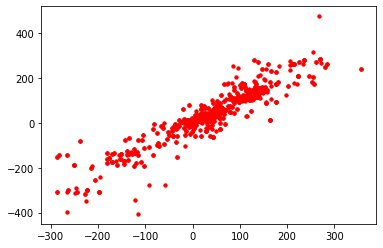

In [20]:
plt.plot(p_test, y_test, 'r.')
np.sqrt(np.mean((p_test-y_test)**2))

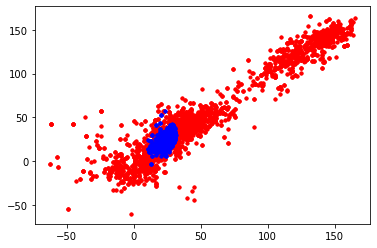

In [21]:
plt.plot(cs[type_idx['C']], cs_pred[type_idx['C']], 'r.')
plt.plot(cs[type_idx['H']], cs_pred[type_idx['H']], 'b.')

In [22]:
sel = FPS(n_to_select = 1000, progress_bar=tqdm)

In [23]:
sel.fit(feats)

FPS()

In [24]:
KBB1 = (feat1[sel.selected_idx_]@feat1[sel.selected_idx_].T)**2
KBB2 = (feat2[sel.selected_idx_]@feat2[sel.selected_idx_].T)**2

In [25]:
rkhs1 = RKHSTransform(jitter=1e-10)
rkhs1.fit(KBB1)
rkhs2 = RKHSTransform(jitter=1e-10)
rkhs2.fit(KBB2)

In [26]:
feats = np.hstack([rkhs1.transform((feat1@feat1[sel.selected_idx_].T)**2), 
                   rkhs2.transform((feat2@feat2[sel.selected_idx_].T)**2)])
X_train, X_test, y_train, y_test, sig_train, sig_test, g_train, g_test = train_test_split_by_frame(frames, feats, cs, sigmas, train_size=0.8)

In [27]:
ar = AtomRidge(sigma=1, delta=[10, 2], feature_groups=[slice(0,rkhs1.nB_), slice(rkhs1.nB_,rkhs1.nB_+rkhs2.nB_)])
splits = list(GroupKFold(n_splits=2).split(X_train, y_train, g_train))
gcv = GridSearchCV(ar, dict(delta=[[1,100], [1,10], [1, 1], [10, 1], [100,1]]), cv = splits, scoring='neg_mean_squared_error')

In [28]:
gcv.fit(X_train, y_train, sample_sigmas=sig_train)

GridSearchCV(cv=[(array([   48,    49,    50, ..., 12806, 12807, 12808]),
                  array([    0,     1,     2, ..., 12658, 12659, 12660])),
                 (array([    0,     1,     2, ..., 12658, 12659, 12660]),
                  array([   48,    49,    50, ..., 12806, 12807, 12808]))],
             estimator=AtomRidge(delta=[10, 2],
                                 feature_groups=[slice(0, 961, None),
                                                 slice(961, 1961, None)],
                                 sigma=1),
             param_grid={'delta': [[1, 100], [1, 10], [1, 1], [10, 1],
                                   [100, 1]]},
             scoring='neg_mean_squared_error')

In [29]:
gcv.cv_results_

{'mean_fit_time': array([0.57306707, 0.56071413, 0.57852292, 0.59785664, 0.66454113]),
 'std_fit_time': array([0.00267851, 0.00508988, 0.00524592, 0.00488198, 0.05927074]),
 'mean_score_time': array([0.08969927, 0.08821619, 0.09062922, 0.09227931, 0.10231376]),
 'std_score_time': array([2.85792351e-03, 5.90682030e-04, 4.64916229e-06, 3.19838524e-04,
        2.43973732e-03]),
 'param_delta': masked_array(data=[list([1, 100]), list([1, 10]), list([1, 1]),
                    list([10, 1]), list([100, 1])],
              mask=[False, False, False, False, False],
        fill_value='?',
             dtype=object),
 'params': [{'delta': [1, 100]},
  {'delta': [1, 10]},
  {'delta': [1, 1]},
  {'delta': [10, 1]},
  {'delta': [100, 1]}],
 'split0_test_score': array([-6871.25681638, -4275.81785461, -2327.1206239 , -2435.99582069,
        -3313.62749191]),
 'split1_test_score': array([-8311.50051452, -4682.43061987, -1994.2089419 , -2013.5957211 ,
        -3163.56645951]),
 'mean_test_score': ar

In [30]:
cs_pred = gcv.predict(feats)

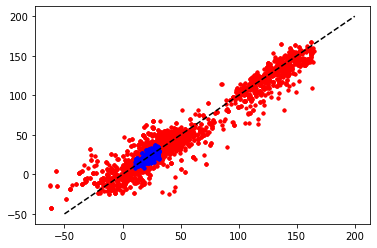

In [31]:
plt.plot(cs[type_idx['C']], cs_pred[type_idx['C']], 'r.')
plt.plot(cs[type_idx['H']], cs_pred[type_idx['H']], 'b.')
plt.plot([-50,200],[-50,200], 'k--')

In [32]:
p_test = gcv.predict(X_test)

37.9234057386919

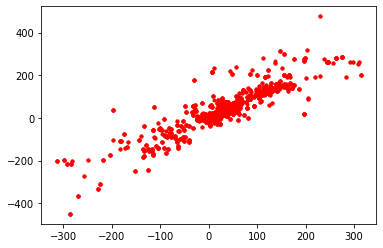

In [33]:
plt.plot(p_test, y_test, 'r.')
np.sqrt(np.mean((p_test-y_test)**2))

In [34]:
feats = np.hstack([feat1, feat2, rkhs1.transform((feat1@feat1[sel.selected_idx_].T)**2), 
                   rkhs2.transform((feat2@feat2[sel.selected_idx_].T)**2)])
ar = AtomRidge(sigma=1, delta=[10, 2], 
               feature_groups=[slice(0,feat1.shape[1]),
                               slice(feat1.shape[1],feat1.shape[1]+feat2.shape[1]),
                               slice(feat1.shape[1]+feat2.shape[1],feat1.shape[1]+feat2.shape[1]+rkhs1.nB_),
                               slice(feat1.shape[1]+feat2.shape[1]+rkhs1.nB_,
                                     feat1.shape[1]+feat2.shape[1]+rkhs1.nB_+rkhs2.nB_)])
X_train, X_test, y_train, y_test, sig_train, sig_test, g_train, g_test = train_test_split_by_frame(frames, feats, cs, sigmas, train_size=0.8)

In [35]:
splits = list(GroupKFold(n_splits=2).split(X_train, y_train, g_train))
gcv = GridSearchCV(ar, dict(delta=[[1,1,1,1], [10,1,1,1], [1, 10, 1, 1], [1, 1, 1,10]]), cv = splits, scoring='neg_mean_squared_error')

In [36]:
gcv.fit(X_train, y_train, sample_sigmas=sig_train)

GridSearchCV(cv=[(array([    0,     1,     2, ..., 12873, 12874, 12875]),
                  array([   86,    87,    88, ..., 12605, 12606, 12607])),
                 (array([   86,    87,    88, ..., 12605, 12606, 12607]),
                  array([    0,     1,     2, ..., 12873, 12874, 12875]))],
             estimator=AtomRidge(delta=[10, 2],
                                 feature_groups=[slice(0, 50, None),
                                                 slice(50, 6770, None),
                                                 slice(6770, 7731, None),
                                                 slice(7731, 8731, None)],
                                 sigma=1),
             param_grid={'delta': [[1, 1, 1, 1], [10, 1, 1, 1], [1, 10, 1, 1],
                                   [1, 1, 1, 10]]},
             scoring='neg_mean_squared_error')

In [37]:
gcv.cv_results_

{'mean_fit_time': array([ 9.85993683, 13.27722335, 12.66051674, 11.67009723]),
 'std_fit_time': array([1.35135758, 1.50251627, 0.07989526, 0.10312021]),
 'mean_score_time': array([1.03893089, 1.13393652, 1.11975455, 0.98259676]),
 'std_score_time': array([0.07027054, 0.11650789, 0.00368428, 0.00716817]),
 'param_delta': masked_array(data=[list([1, 1, 1, 1]), list([10, 1, 1, 1]),
                    list([1, 10, 1, 1]), list([1, 1, 1, 10])],
              mask=[False, False, False, False],
        fill_value='?',
             dtype=object),
 'params': [{'delta': [1, 1, 1, 1]},
  {'delta': [10, 1, 1, 1]},
  {'delta': [1, 10, 1, 1]},
  {'delta': [1, 1, 1, 10]}],
 'split0_test_score': array([-2254.38191997, -2350.89008397, -2407.5595815 , -4178.02238631]),
 'split1_test_score': array([-1904.86760492, -1755.33312981, -2329.76061556, -5183.96133146]),
 'mean_test_score': array([-2079.62476245, -2053.11160689, -2368.66009853, -4680.99185888]),
 'std_test_score': array([174.75715753, 297.77847

In [53]:
cs_pred = gcv.predict(feats)

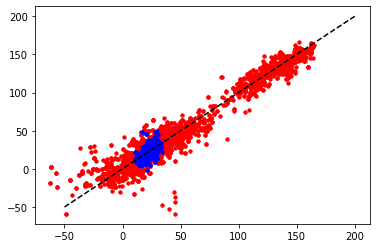

In [54]:
plt.plot(cs[type_idx['C']], cs_pred[type_idx['C']], 'r.')
plt.plot(cs[type_idx['H']], cs_pred[type_idx['H']], 'b.')
plt.plot([-50,200],[-50,200], 'k--')

In [55]:
p_test = gcv.predict(X_test)

33.52512284197961

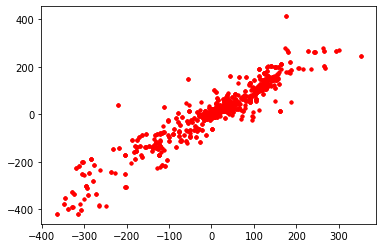

In [56]:
plt.plot(p_test, y_test, 'r.')
np.sqrt(np.mean((p_test-y_test)**2))

# Tensor stuff

In [9]:
cg = ClebschGordanReal(lmax=2)

In [10]:
tcs_coupled = cg.couple(xyz_to_spherical(tcs))

In [11]:
tcs_cart = spherical_to_xyz(cg.decouple(tcs_coupled))

In [12]:
tcs[0]

array([[  61.3422, -101.3244,   47.903 ],
       [-105.0865,  -13.6984,  -34.2244],
       [  35.4635,  -54.8832,   60.0297]])

In [13]:
print(tcs_coupled[(1,1)][0][0], tcs_coupled[(1,1)][1][0], tcs_coupled[(1,1)][2][0])

[-62.16532421] [-8.7960548   2.66020642 14.60797757] [-145.9545471   -63.00858822   29.5635449    58.94901747   53.06171712]


In [14]:
tcs_cart[0]

array([[  61.3422, -101.3244,   47.903 ],
       [-105.0865,  -13.6984,  -34.2244],
       [  35.4635,  -54.8832,   60.0297]])

In [15]:
cs[0]*np.sqrt(3)

62.163303483647006

In [16]:
tcs[0].trace()/3

35.89116666666666

In [17]:
tcs_coupled[(1,1)][2]

array([[-145.9545471 ,  -63.00858822,   29.5635449 ,   58.94901747,
          53.06171712],
       [ 145.9545471 ,  -63.00858822,   29.5635449 ,  -58.94901747,
          53.06171712],
       [ 145.9545471 ,   63.00858822,   29.5635449 ,   58.94901747,
          53.06171712],
       ...,
       [   3.03405378,   -3.12788685,    0.84454324,   -2.4951677 ,
           2.93937218],
       [  -3.03405378,    3.12788685,    0.84454324,   -2.4951677 ,
           2.93937218],
       [   3.03405378,   -3.12788685,    0.84454324,   -2.4951677 ,
           2.93937218]])

## builds lambda-SOAP

In [68]:
hypers_2 = {
    'interaction_cutoff': 6,
    'max_radial': 8,
    'max_angular': 6,
    'gaussian_sigma_type': 'Constant',
    'gaussian_sigma_constant': 0.2,
    'cutoff_smooth_width': 0.3,
    'radial_basis': 'DVR'
}
hypers_2 = get_optimal_radial_basis_hypers(hypers_2, frames, expanded_max_radial=50)

In [69]:
CG = ClebschGordanReal(lmax=hypers_2["max_angular"])

In [70]:
spex = SphericalExpansion(**hypers_2)

In [71]:
feats = spex.transform(frames).get_features(spex)
ref_feats = 1e3*spherical_expansion_reshape(feats, **hypers_2)

In [238]:
isel =type_idx['H'][::10]
nsel = len(isel)

In [239]:
nsel

643

In [181]:
lsoap = compute_lambda_soap(ref_feats[isel], CG, 2, 1)

this is a simple PCA contraction

In [172]:
lsr = np.moveaxis(lsoap,-1,1).reshape((lsoap.shape[0]*lsoap.shape[-1], -1))

In [173]:
u, s, vt = sp.linalg.svd(lsr, full_matrices=False)

(0.01, 10000.0)

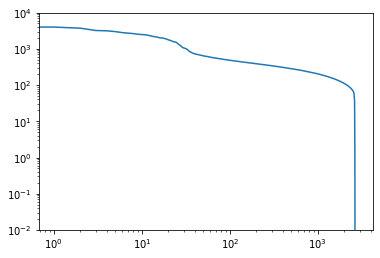

In [178]:
plt.loglog(s)
plt.ylim(1e-2,1e4)

In [28]:
vt.shape

(2515, 9000)

In [29]:
lsoap_pca = np.moveaxis((lsr@vt[:1000].T).reshape((lsoap.shape[0], lsoap.shape[-1], -1)), 1, -1)

In [30]:
lsoap_pca.shape

(503, 1000, 5)

now do 0-1-2

no - pca

In [148]:
lsoap0 = compute_lambda_soap(ref_feats[:nsel], CG, 0, 1)
lsoap0.shape = (lsoap0.shape[0], -1, lsoap0.shape[-1])
lsoap1 = compute_lambda_soap(ref_feats[:nsel], CG, 1, -1)
lsoap1.shape = (lsoap1.shape[0], -1, lsoap1.shape[-1])
lsoap2 = compute_lambda_soap(ref_feats[:nsel], CG, 2, 1)
lsoap2.shape = (lsoap2.shape[0], -1, lsoap2.shape[-1])

pca

In [240]:
lsoap0 = compute_lambda_soap(ref_feats[isel], CG, 0, 1)
lsr = np.moveaxis(lsoap0,-1,1).reshape((lsoap0.shape[0]*lsoap0.shape[-1], -1))
u, s, vt = sp.linalg.svd(lsr, full_matrices=False)
lsoap0 = np.moveaxis((lsr@vt[:1000].T).reshape((lsoap0.shape[0], lsoap0.shape[-1], -1)), 1, -1)

In [241]:
lsoap1 = compute_lambda_soap(ref_feats[isel], CG, 1, -1)
lsr = np.moveaxis(lsoap1,-1,1).reshape((lsoap1.shape[0]*lsoap1.shape[-1], -1))
u, s, vt = sp.linalg.svd(lsr, full_matrices=False)
lsoap1 = np.moveaxis((lsr@vt[:1000].T).reshape((lsoap1.shape[0], lsoap1.shape[-1], -1)), 1, -1)

In [242]:
lsoap2 = compute_lambda_soap(ref_feats[isel], CG, 2, 1)
lsr = np.moveaxis(lsoap2,-1,1).reshape((lsoap2.shape[0]*lsoap2.shape[-1], -1))
u, s, vt = sp.linalg.svd(lsr, full_matrices=False)
lsoap2 = np.moveaxis((lsr@vt[:1000].T).reshape((lsoap2.shape[0], lsoap2.shape[-1], -1)), 1, -1)

In [107]:
from sklearn.linear_model import Ridge

In [124]:
class SASplitter:
    """ CV splitter that takes into account the presence of "L blocks"
    associated with symmetry-adapted regression. Basically, you can trick conventional
    regression schemes to work on symmetry-adapted data y^M_L(A_i) by having the (2L+1)
    angular channels "unrolled" into a flat array. Then however splitting of train/test
    or cross validation must not "cut" across the M block. This takes care of that.
    """
    def __init__(self, L, cv=2):
        self.L = L
        self.cv = cv
        self.n_splits = cv

    def split(self, X, y, groups=None):

        ntrain = X.shape[0]
        if ntrain % (2*self.L+1) != 0:
            raise ValueError("Size of training data is inconsistent with the L value")
        ntrain = ntrain // (2*self.L+1)
        nbatch = (2*self.L+1)*(ntrain//self.n_splits)
        idx = np.arange(len(X))
        np.random.shuffle(idx)
        for n in range(self.n_splits):
            itest = idx[n*nbatch:(n+1)*nbatch]
            itrain = np.concatenate([idx[:n*nbatch], idx[(n+1)*nbatch:]])
            yield itrain, itest

    def get_n_splits(self, X, y, groups=None):
        return self.n_splits
    
class SARidge(Ridge):
    """ Symmetry-adapted ridge regression class """

    def __init__(self, L, alpha=1, alphas=None, cv=2, solver='auto',
                 fit_intercept=False, scoring='neg_root_mean_squared_error'):
        self.L = L
        # L>0 components have zero mean by symmetry
        if L>0:
            fit_intercept = False
        self.cv = SASplitter(L, cv)
        self.alphas = alphas
        self.cv_stats = None
        self.scoring = scoring
        self.solver = solver
        super(SARidge, self).__init__(alpha=alpha, fit_intercept=fit_intercept, solver=solver)

    def fit(self, Xm, Ym, X0=None):
        # this expects properties in the form [i, m] and features in the form [i, q, m]
        # in order to train a SA-GPR model the m indices have to be moved and merged with the i

        Xm_flat = np.moveaxis(Xm, 2, 1).reshape((-1, Xm.shape[1]))
        Ym_flat = Ym.flatten()
        if self.alphas is not None:
            # determines alpha by grid search
            rcv = Ridge(fit_intercept=self.fit_intercept)
            gscv = GridSearchCV(rcv, dict(alpha=self.alphas), cv=self.cv, scoring=self.scoring)
            gscv.fit(Xm_flat, Ym_flat)
            self.cv_stats = gscv.cv_results_
            self.alpha = gscv.best_params_["alpha"]

        super(SARidge, self).fit(Xm_flat, Ym_flat)
    def predict(self, Xm, X0=None):

        Y = super(SARidge, self).predict(np.moveaxis(Xm, 2, 1).reshape((-1, Xm.shape[1])))
        return Y.reshape((-1, 2*self.L+1))

In [243]:
tgt0 = tcs_coupled[(1,1)][0][isel]
tgt1 = tcs_coupled[(1,1)][1][isel]
tgt2 = tcs_coupled[(1,1)][2][isel]

In [256]:
reg = 1e3
sar0 = SARidge(L=0, alpha=reg)
sar1 = SARidge(L=1, alpha=reg)
sar2 = SARidge(L=2, alpha=reg)

In [257]:
sar0.fit(lsoap0[::2], tgt0[::2])
sar1.fit(lsoap1[::2], tgt1[::2])
sar2.fit(lsoap2[::2], tgt2[::2])

In [258]:
pred0 = sar0.predict(lsoap0)
pred1 = sar1.predict(lsoap1)
pred2 = sar2.predict(lsoap2)

2.2131415444738542


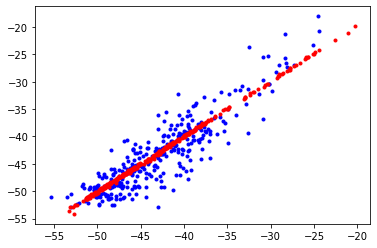

In [259]:
plt.plot(pred0[1::2], tgt0[1::2], 'b.')
plt.plot(pred0[::2], tgt0[::2], 'r.')
print(np.mean(np.abs(pred0[1::2]-tgt0[1::2])))

0.977980063501437


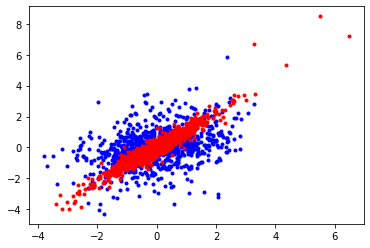

In [260]:
plt.plot(pred1[1::2].flatten(), tgt1[1::2].flatten(), 'b.')
plt.plot(pred1[::2].flatten(), tgt1[::2].flatten(), 'r.')
print(np.mean(np.abs(pred1[1::2]-tgt1[1::2])))

1.5383210083715102


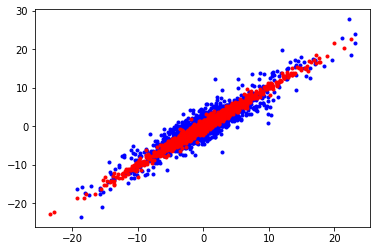

In [261]:
plt.plot(pred2[1::2].flatten(), tgt2[1::2].flatten(), 'b.')
plt.plot(pred2[::2].flatten(), tgt2[::2].flatten(), 'r.')
print(np.mean(np.abs(pred2[1::2]- tgt2[1::2])))